# Intel&reg; OSPRay - Implementation of OIDN

## Module Overview

The module focuses on utilizing Intel® OSPRay with Intel® Open Image Denoise (OIDN) to create a denoiser pass within OSPRay programs. It outlines the learning objectives, including using OSPRay to integrate a denoiser pass powered by Open Image Denoise. The tutorial provides code snippets demonstrating the process of adding a denoiser pass to an OSPRay program, highlighting the straightforward implementation. Additionally, it covers building the code and running the program, showcasing the rendering results. The summary emphasizes the completion of the lesson, highlighting the review, building, and running of a basic OSPRay program with Open Image Denoise enabled. Finally, it provides additional resources, such as the OSPRay API manual, for further exploration.

## Learning Objectives

* Utilize Intel® OSPRay to create a denoiser pass within OSPRay programs.
* Understand the process of integrating Intel® Open Image Denoise into OSPRay rendering pipelines for noise reduction.


***
### 1. Denoise through Intel OSPRay API

Try the `ospTutorial_denoise` program! `ospTutorial_denoise` performs the same render as the previous `ospTutorial` program, however, it adds a denoiser pass. Compare and contrast... then try the source code below to see how to add a denoiser pass to your render. 

To summarize, the Open Image Denoise implementation in the OSPRay ```ospTutorial.cpp``` program is:

```sh
  // ########## OIDN imageOperation setup
  std::vector<ospray::cpp::ImageOperation> imops = {ospray::cpp::ImageOperation("denoiser")};
  imops[0].commit();

  ospray::cpp::Data fbImageOpData(imops);
  fbImageOpData.commit();

  framebuffer.setParam("imageOperation", ospray::cpp::CopiedData(fbImageOpData));
  // ########## OIDN imageOperation setup end 

  framebuffer.commit();
```

As you can see, this process is very straigforward and by adding this piece of code in `ospTutorial` the new output figure will denoised as we will see in this module.  You can search this implementation in the code below so see where it has been injected:

In [1]:
%%writefile src/ospTutorial_denoise.cpp


// Copyright 2024 Intel Corporation
// SPDX-License-Identifier: Apache-2.0

/* This is a small example tutorial how to use OSPRay in an application.
 *
 * On Linux build it in the build_directory with
 *   g++ ../apps/ospTutorial/ospTutorial.cpp -I ../ospray/include \
 *       -I ../../rkcommon -L . -lospray -Wl,-rpath,. -o ospTutorial
 * On Windows build it in the build_directory\$Configuration with
 *   cl ..\..\apps\ospTutorial\ospTutorial.cpp /EHsc -I ..\..\ospray\include ^
 *      -I ..\.. -I ..\..\..\rkcommon ospray.lib
 * Above commands assume that rkcommon is present in a directory right "next
 * to" the OSPRay directory. If this is not the case, then adjust the include
 * path (alter "-I <path/to/rkcommon>" appropriately).
 */
// system includes
#ifdef _WIN32
#define NOMINMAX
#include <conio.h>
#include <malloc.h>
#include <windows.h>
#else
#include <alloca.h>
#endif
#include <errno.h>
#include <stdint.h>
#include <stdio.h>

// ospray includes
#include "ospray/ospray_cpp.h"
#include "ospray/ospray_util.h"
#include "ospray/ospray_cpp/ext/rkcommon.h"

// includes to STB for writing out a PNG image
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"

#include <vector>

// For .ppm, .pfm support
#include "rkcommon/utility/SaveImage.h"

using namespace rkcommon::math;

// ################################################################################
// A simple function that uses the STB library to write out the float framebuffer in
// PNG format.

void writeHDPNG(const char *fileName, const vec2i &size, const float *pixel) {
  constexpr int nChannels{4};
  const int stride{nChannels * size.x};
  /* Added for OIDN */
  uint32_t* pxout = (uint32_t*)malloc(sizeof(uint32_t)*size.x*size.y);
  for(int j = 0; j < size.y; j++) {
   for(int i = 0; i < size.x; i++) {
       uint32_t r = (unsigned char)clamp(pixel[j * nChannels * size.x + i * nChannels] * 255.f, 0.f, 255.0f);
       uint32_t g = (unsigned char)clamp(pixel[j * nChannels * size.x + i * nChannels + 1] * 255.f, 0.f, 255.0f);
       uint32_t b = (unsigned char)clamp(pixel[j * nChannels * size.x + i * nChannels + 2] * 255.f, 0.f, 255.0f);
       uint32_t a = (unsigned char)clamp(pixel[j * nChannels * size.x + i * nChannels + 3] * 255.f, 0.f, 255.0f);
       pxout[(size.y - j -1) * size.x + i] = (a << 24) | (b << 16) | (g << 8) | r;
       //Repack the color channels
       //Example for r... here are is where r should be for the pxout array of uint32_t objects: 0x000000000000FFFFh
       //Example for r in a binary representation of the above 0x00000000000000000000000011111111b
       //Example for g... here are is where g should be for the pxout array of uint32_t objects: 0x00000000FFFF0000h
       //Example for g in a binary representation of the above 0x00000000000000001111111100000000b
   }
  }
        
  stbi_write_png(fileName, size.x, size.y, nChannels, pxout, stride);
  if(pxout) { 
      free(pxout);
      pxout = 0;
  }
}
      
void writePNG(const char *fileName, const vec2i &size, const uint32_t *pixel) {
  constexpr int nChannels{4};
  const int stride{nChannels * size.x};  
  stbi_write_png(fileName, size.x, size.y, nChannels, pixel, stride);

}

int main(int argc, const char **argv)
{
  // image size
  vec2i imgSize;
  imgSize.x = 1024; // width
  imgSize.y = 768; // height

  // camera
  vec3f cam_pos{0.f, 0.f, 0.f};
  vec3f cam_up{0.f, 1.f, 0.f};
  vec3f cam_view{0.1f, 0.f, 1.f};

  // triangle mesh data
  std::vector<vec3f> vertex = {vec3f(-1.0f, -1.0f, 3.0f),
      vec3f(-1.0f, 1.0f, 3.0f),
      vec3f(1.0f, -1.0f, 3.0f),
      vec3f(0.1f, 0.1f, 0.3f)};

  std::vector<vec4f> color = {vec4f(0.9f, 0.5f, 0.5f, 1.0f),
      vec4f(0.8f, 0.8f, 0.8f, 1.0f),
      vec4f(0.8f, 0.8f, 0.8f, 1.0f),
      vec4f(0.5f, 0.9f, 0.5f, 1.0f)};

  std::vector<vec3ui> index = {vec3ui(0, 1, 2), vec3ui(1, 2, 3)};

#ifdef _WIN32
  bool waitForKey = false;
  CONSOLE_SCREEN_BUFFER_INFO csbi;
  if (GetConsoleScreenBufferInfo(GetStdHandle(STD_OUTPUT_HANDLE), &csbi)) {
    // detect standalone console: cursor at (0,0)?
    waitForKey = csbi.dwCursorPosition.X == 0 && csbi.dwCursorPosition.Y == 0;
  }
#endif

  // initialize OSPRay; OSPRay parses (and removes) its command line parameters,
  // e.g. "--osp:debug
  OSPError init_error = ospInit(&argc, argv);
  if (init_error != OSP_NO_ERROR)
    return init_error;

  // ########## New for denoising... this brings in the runtime connecting Intel Open Image Denoise to Intel OSPRay API
  // initialize denoiser module
  if( !(ospLoadModule("denoiser") == OSP_NO_ERROR )) {
       std::cout << "error loading ospray denoiser\n";
    return -1;
  }
  

  // use scoped lifetimes of wrappers to release everything before ospShutdown()
  {
    // create and setup camera
    ospray::cpp::Camera camera("perspective");
    camera.setParam("aspect", imgSize.x / (float)imgSize.y);
    camera.setParam("position", cam_pos);
    camera.setParam("direction", cam_view);
    camera.setParam("up", cam_up);
    camera.commit(); // commit each object to indicate modifications are done

    // create and setup model and mesh
    ospray::cpp::Geometry mesh("mesh");
    mesh.setParam("vertex.position", ospray::cpp::CopiedData(vertex));
    mesh.setParam("vertex.color", ospray::cpp::CopiedData(color));
    mesh.setParam("index", ospray::cpp::CopiedData(index));
    mesh.commit();

    // put the mesh into a model
    ospray::cpp::GeometricModel model(mesh);
    model.commit();

    // put the model into a group (collection of models)
    ospray::cpp::Group group;
    group.setParam("geometry", ospray::cpp::CopiedData(model));
    group.commit();

    // put the group into an instance (give the group a world transform)
    ospray::cpp::Instance instance(group);
    instance.commit();

    // put the instance in the world
    ospray::cpp::World world;
    world.setParam("instance", ospray::cpp::CopiedData(instance));

    // create and setup light for Ambient Occlusion
    ospray::cpp::Light light("ambient");
    light.commit();

    world.setParam("light", ospray::cpp::CopiedData(light));
    world.commit();

    // create renderer, choose Scientific Visualization renderer
    ospray::cpp::Renderer renderer("scivis");

    // complete setup of renderer
    renderer.setParam("aoSamples", 1);
    renderer.setParam("backgroundColor", 1.0f); // white, transparent
    renderer.commit();

    // ########## New for denoising: create and setup a float frame buffer OSP_FB_RGBA32F,   
    ospray::cpp::FrameBuffer framebuffer =
      ospNewFrameBuffer(imgSize.x, imgSize.y, OSP_FB_RGBA32F,
                        OSP_FB_COLOR | /*OSP_FB_DEPTH |*/ OSP_FB_ACCUM);
    framebuffer.clear();
    
    // ########## OIDN imageOperation setup, a pure c version is commented out
    std::vector<ospray::cpp::ImageOperation> imops = { ospray::cpp::ImageOperation("denoiser") };
    imops[0].commit();
    //OSPImageOperation imops[1];
    //imops[0] = ospNewImageOperation("denoiser");
    //ospCommit(imops[0]);
    ospray::cpp::Data fbImageOpData(imops);
    fbImageOpData.commit();
    //data = ospNewSharedData1D(imops, OSP_IMAGE_OPERATION, 1);
    //ospCommit(data);
    //ospSetObject(framebuffer, "imageOperation", data);  
    //ospCommit(framebuffer);
    framebuffer.setParam("imageOperation", ospray::cpp::CopiedData(fbImageOpData));
    // ########## OIDN imageOperation setup end 
    framebuffer.commit();

    // ########## The C-API pattern for denoise looks like this:
    //OSPImageOperation imops[1];
    //imops[0] = ospNewImageOperation("denoiser");
    //ospCommit(imops[0]);
    //data = ospNewSharedData1D(imops, OSP_IMAGE_OPERATION, 1);
    //ospCommit(data);
    //ospSetObject(framebuffer, "imageOperation", data);  
    //ospCommit(framebuffer);
    // ########## C-API denoise pattern end

    // render one frame
    framebuffer.renderFrame(renderer, camera, world);

    // access framebuffer and write its content as PPM file
    // ########## New for denoising, cast and read from the float* buffer where you need it. writePFM(..) is overloaded for various packed value orderings in SaveImage.h
    float *fb = (float *)framebuffer.map(OSP_FB_COLOR);
    rkcommon::utility::writePFM("firstFrameCppDenoise.pfm", imgSize.x, imgSize.y, (vec3fa*)fb);
    writeHDPNG("firstFrameCppDenoise.png", imgSize, fb);
    framebuffer.unmap(fb);
    std::cout << "rendering initial frame to firstFrameCppDenoise.pfm/png" << std::endl;

    // render 10 more frames, which are accumulated to result in a better
    // converged image
    for (int frames = 0; frames < 10; frames++)
      framebuffer.renderFrame(renderer, camera, world);

    fb = (float *)framebuffer.map(OSP_FB_COLOR);
    rkcommon::utility::writePFM(
        "accumulatedFrameCppDenoise.pfm", imgSize.x, imgSize.y, (vec3fa*)fb);
    writeHDPNG(
        "accumulatedFrameCppDenoise.png", imgSize, fb);
    framebuffer.unmap(fb);
    std::cout << "rendering 10 accumulated frames to accumulatedFrameCppDenoise.pfm/png"
              << std::endl;

    ospray::cpp::PickResult res =
        framebuffer.pick(renderer, camera, world, 0.5f, 0.5f);

    if (res.hasHit) {
      std::cout << "picked geometry [instance: " << res.instance.handle()
                << ", model: " << res.model.handle()
                << ", primitive: " << res.primID << "]" << std::endl;
    }
  }

  ospShutdown();

#ifdef _WIN32
  if (waitForKey) {
    printf("\n\tpress any key to exit");
    _getch();
  }
#endif

  return 0;
}


Overwriting src/ospTutorial_denoise.cpp


***

### 3. Build the Code

In [2]:
! ./build_denoise.sh

 
:: initializing oneAPI environment ...
   build_denoise.sh: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: --force
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: embree -- latest
:: inspector -- latest
:: ipp -- latest
:: ippcp -- latest
:: ispc -- latest
:: itac -- latest
:: mkl -- latest
:: mpi -- latest
:: oidn -- latest
:: openpgl -- latest
:: openvkl -- latest
:: ospray -- latest
:: ospray_studio -- latest
:: rkcommon -- latest
:: rkutil -- latest
:: tbb -- latest
:: vtune -- latest
:: oneAPI environment initialized ::
 
## ue67fcfb20b4827a1ed6842c10ec58c1 is compiling OSPRay_Intro with denoise (ospTutorial_denoise)
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compil

***

### 4. Run the Program

In [3]:
! ./run_denoise.sh

## ue67fcfb20b4827a1ed6842c10ec58c1 is running OSPRay_Intro with denoise (ospTutorial_denoise)
rendering initial frame to firstFrameCppDenoise.pfm/png
rendering 10 accumulated frames to accumulatedFrameCppDenoise.pfm/png
picked geometry [instance: 0x556d85a62150, model: 0x556d85a5b430, primitive: 1]


***

### 5. View the Converted Image

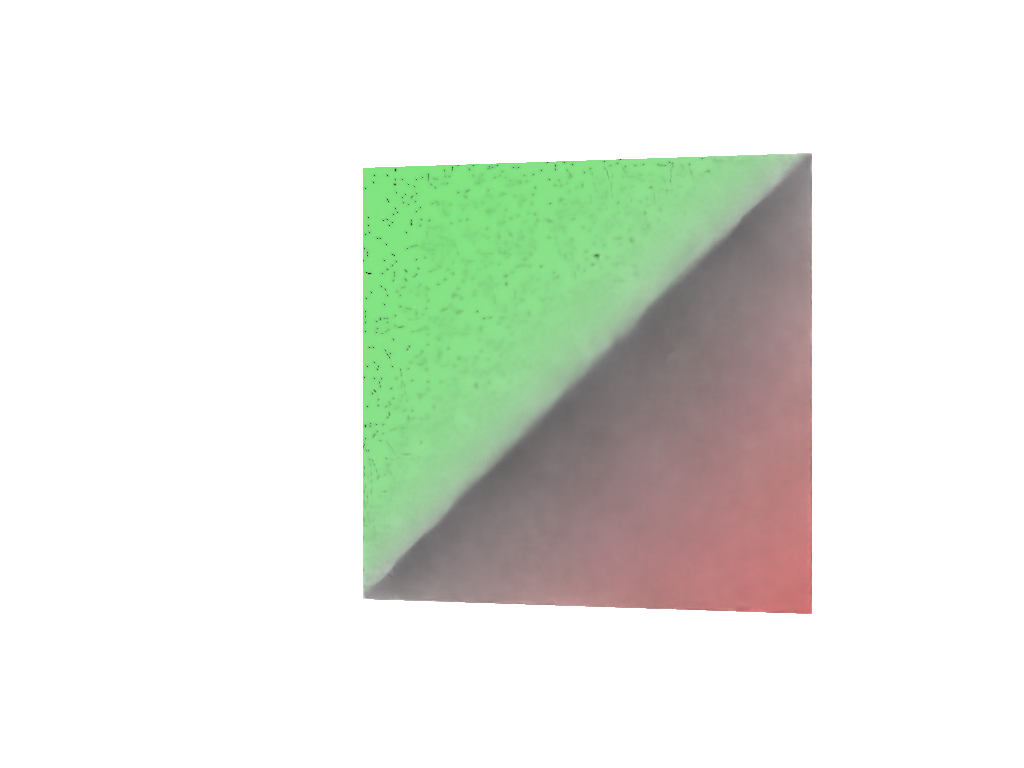

In [4]:
from IPython.display import Image
Image("firstFrameCppDenoise.png")

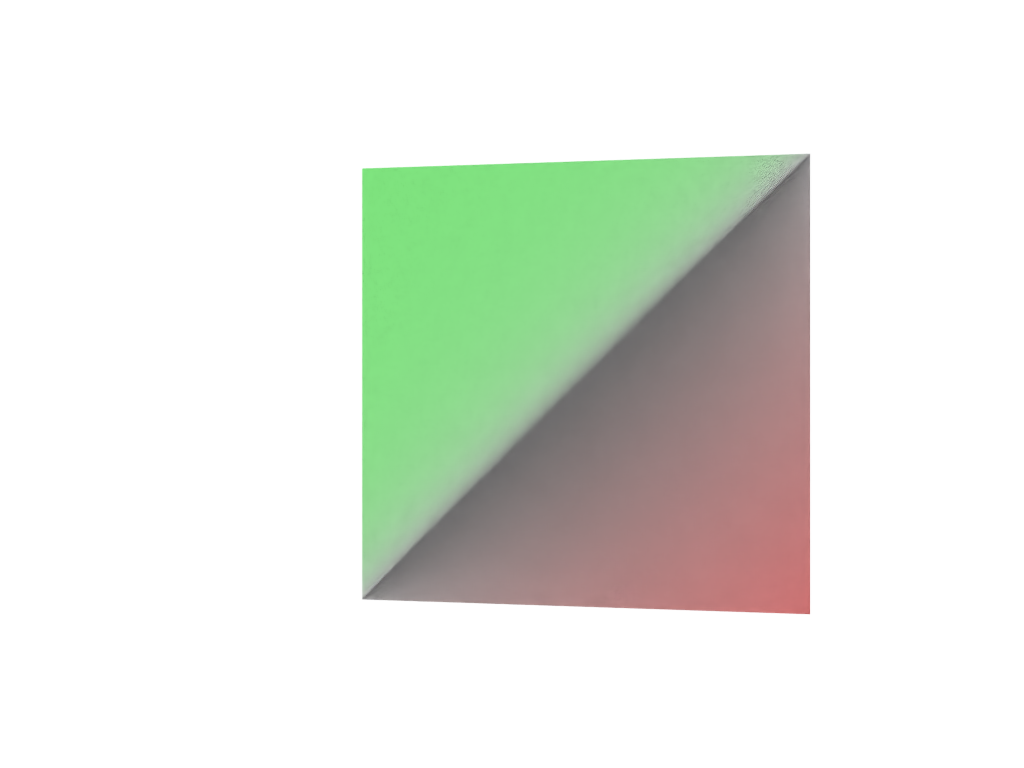

In [5]:
Image("accumulatedFrameCppDenoise.png")

***
## Summary

In this module you learned:

* Reviewed, built, and ran a basic Intel&reg; OSPRay program with Intel&reg; Open Image Denoise enabled.

## Resources
* Intel&reg; OSPRay API manual: https://www.ospray.org/documentation.html


***